In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from lightfm.lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score, reciprocal_rank
from scipy.sparse import coo_matrix, csr_matrix

%matplotlib inline
sns.set_context('notebook', font_scale=1.6)

# Load Movielens data

In [5]:
from lightfm.datasets import fetch_movielens
movielens = fetch_movielens(min_rating=4.0)

In [6]:
for k, v in movielens.iteritems():
    print('key: {:>20},    data_type: {:>13}'
          .format(k, v.__class__.__name__))

key:                 test,    data_type:    coo_matrix
key:        item_features,    data_type:    csr_matrix
key:                train,    data_type:    coo_matrix
key:          item_labels,    data_type:       ndarray
key:  item_feature_labels,    data_type:       ndarray


In [7]:
train = movielens['train']
test = movielens['test']

print 'train:\n-----\n{}'.format(repr(train))
display(pd.DataFrame(train.todense(), columns=movielens['item_labels']).iloc[:5, :5])
print '\ntest:\n-----\n{}'.format(repr(test))
display(pd.DataFrame(test.todense(), columns=movielens['item_labels']).iloc[:5, :5])

train:
-----
<943x1682 sparse matrix of type '<type 'numpy.int32'>'
	with 49906 stored elements in COOrdinate format>


,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995)
0,5,0,4,0,0
1,4,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0



test:
-----
<943x1682 sparse matrix of type '<type 'numpy.int32'>'
	with 5469 stored elements in COOrdinate format>


,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995)
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,4,0,0,0,0


In [8]:
t = (
    pd.DataFrame(
        zip(
            movielens['item_labels'],
            movielens['item_feature_labels']
            ),
        columns=['item_labels', 'item_feature_labels']
    )
    .assign(delta=lambda df:
            df['item_labels'] != df['item_feature_labels'])
)

display(t.head())
print '\ndescribe on delta column:\n-------------'
print t.delta.describe()

,item_labels,item_feature_labels,delta
0,Toy Story (1995),Toy Story (1995),False
1,GoldenEye (1995),GoldenEye (1995),False
2,Four Rooms (1995),Four Rooms (1995),False
3,Get Shorty (1995),Get Shorty (1995),False
4,Copycat (1995),Copycat (1995),False



describe on delta column:
-------------
count      1682
unique        1
top       False
freq       1682
Name: delta, dtype: object


# Fit Implicit MF model with BPR optimization

In [9]:
model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(train, epochs=20)

In [10]:
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.33, test 0.04.
AUC: train 0.86, test 0.85.


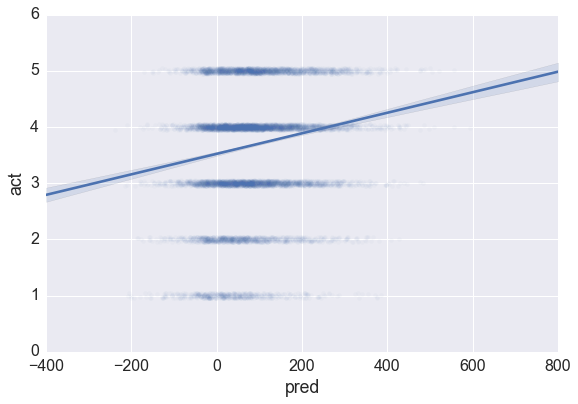

In [103]:
preds = pd.DataFrame(
    zip(
        test.data,
        model.predict(test.row, test.col)
    ), columns=['act', 'pred']
    )

sns.lmplot(data=preds,
           x='pred',
           y='act',
           y_jitter=0.05,
           scatter_kws={'alpha':0.03},
           size=6,
           aspect=1.4,
           robust=True
          )
plt.show()


# Fit Implicit MF model with WARP optimization

In [43]:
model = LightFM(learning_rate=0.05, loss='warp')

model.fit_partial(data['train'], epochs=10)

train_precision = precision_at_k(model, data['train'], k=10).mean()
test_precision = precision_at_k(model, data['test'], k=10).mean()

train_auc = auc_score(model, data['train']).mean()
test_auc = auc_score(model, data['test']).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.60, test 0.11.
AUC: train 0.93, test 0.90.


# Working with Learning rates

In [76]:
def plot_results(epochs, adagrad_auc, adadelta_auc):
    temp = (
        pd.DataFrame(
            zip(xrange(epochs), adagrad_auc, adadelta_auc),
            columns=['epochs', 'adagrad', 'adadelta']
            )
    )

    temp = (
        pd.melt(temp, id_vars=['epochs'],
                value_vars=['adagrad', 'adadelta'],
                var_name='Learning Method',
                value_name='AUC Score')
    )

    g = sns.FacetGrid(data=temp, hue='Learning Method', size=7, aspect=1.4)
    g.map(plt.plot, 'epochs', 'AUC Score')
    plt.show()

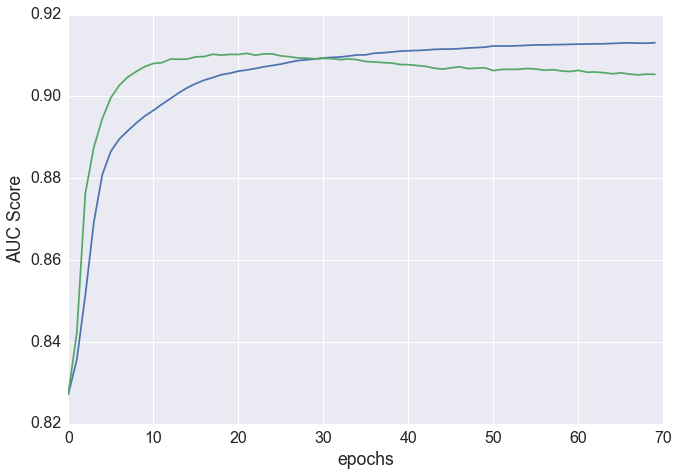

In [77]:
alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adagrad',
                        user_alpha=alpha,
                        item_alpha=alpha)

adadelta_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adadelta',
                        user_alpha=alpha,
                        item_alpha=alpha)

adagrad_auc = []
adadelta_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(data['train'], epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, data['test']).mean())

    adadelta_model.fit_partial(data['train'], epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, data['test']).mean())
    
plot_results(epochs, adagrad_auc, adadelta_auc)

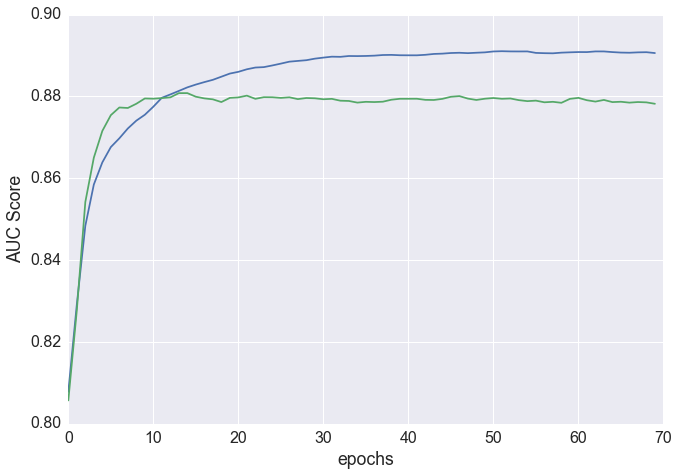

In [78]:
alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=30,
                        loss='warp-kos',
                        learning_schedule='adagrad',
                        user_alpha=alpha,
                        item_alpha=alpha)

adadelta_model = LightFM(no_components=30,
                        loss='warp-kos',
                        learning_schedule='adadelta',
                        user_alpha=alpha,
                        item_alpha=alpha)

adagrad_auc = []
adadelta_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(data['train'], epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, data['test']).mean())

    adadelta_model.fit_partial(data['train'], epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, data['test']).mean())
    
plot_results(epochs, adagrad_auc, adadelta_auc)

# Cold Start with hybrid recommender

In [80]:
from lightfm.datasets import fetch_stackexchange
data = fetch_stackexchange('crossvalidated',
                           test_set_fraction=0.1,
                           indicator_features=False,
                           tag_features=True)

train = data['train']
test = data['test']

In [81]:
print('The dataset has %s users and %s items, '
      'with %s interactions in the test and %s interactions in the training set.'
      % (train.shape[0], train.shape[1], test.getnnz(), train.getnnz()))

The dataset has 3221 users and 72360 items, with 4307 interactions in the test and 57830 interactions in the training set.


In [84]:
NUM_COMPONENTS = 30
NUM_EPOCHS = 3
ITEM_ALPHA = 1e-6

# Let's fit a WARP model: these generally have the best performance.
model = LightFM(loss='warp',
                item_alpha=ITEM_ALPHA,
                no_components=NUM_COMPONENTS)

# Run 3 epochs and time it.
%time model = model.fit(train, epochs=NUM_EPOCHS)

CPU times: user 410 ms, sys: 17.2 ms, total: 427 ms
Wall time: 427 ms


In [91]:
model.item_biases *= 0.0

train_auc = auc_score(model, train).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

test_auc = auc_score(model, test, train_interactions=train).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

Collaborative filtering train AUC: 0.938122
Collaborative filtering test AUC: 0.506422


In [106]:
# Define a new model instance
model = LightFM(loss='warp',
                item_alpha=ITEM_ALPHA,
                no_components=NUM_COMPONENTS)

# Fit the hybrid model. Note that this time, we pass
# in the item features matrix.
model = model.fit(train,
                  item_features=data['item_features'],
                  epochs=NUM_EPOCHS)

In [109]:
train_auc = auc_score(model,
                      train,
                      item_features=data['item_features']
                     ).mean()
print('Hybrid training set AUC: %s' % train_auc)

Hybrid training set AUC: 0.854395


In [165]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

sc = StandardScaler(with_std=False)
x = sc.fit_transform(model.item_embeddings)
cs = cosine_similarity(x)

for tag in [u'bayesian', u'regression', u'survival']:
    tag_id = np.argmax(data['item_feature_labels'] == tag)
    inds = cs[:, tag_id].argsort()[-2:-5:-1]
    print 'Most similar tags for {}: {}'.format(tag, data['item_feature_labels'][inds].tolist())

Most similar tags for bayesian: [u'posterior', u'gibbs', u'mcmc']
Most similar tags for regression: [u'regression-coefficients', u'coefficient-of-variation', u'vector-fields']
Most similar tags for survival: [u'cox-model', u'epidemiology', u'logrank']
